In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
def squared_euclidean_distance(x_1,x_2):
    sqd = np.sqrt(np.reshape(np.sum(x_1**2,1),newshape =(x_1.shape[0],1))+\
    np.reshape(np.sum(x_2**2,1),newshape =(1,x_2.shape[0]))-\
    2*(x_1@x_2.T))
    return sqd

def cartesian_dist(x_1,x_2):
    return np.concatenate([
        np.tile(x_1[:,0] - np.reshape(x_2[:,0],[x_2.shape[0],1]),[1,2]),
        np.tile(x_1[:,1] - np.reshape(x_2[:,1],[x_2.shape[0],1]),[1,2])],axis = 0) 

def cov_gradients(dist_tiled,h_u,h_v,a_T,perpendicularity_matrix):
    c_o_T = a_T**2/14/3
    condition1 = 0
    a = (h_u*h_v)
    b = dist_tiled**2

    t1 =  np.divide(a, b, out=np.zeros_like(a),casting='unsafe', where=b!=0)
    t2 = np.where(dist_tiled < a_T,(-c_o_T*((-14/a_T**2)+
                 105/4*dist_tiled/a_T**3 -
                 35/2 * dist_tiled**3 / a_T **5 +
                 21 /4 * dist_tiled**5/a_T**7)),0)+\
          np.where(dist_tiled < a_T,(c_o_T * 7 * (9 * dist_tiled ** 5 -
                      20 * a_T ** 2 * dist_tiled ** 3 +
                      15 * a_T ** 4 * dist_tiled -
                      4 * a_T ** 5) / (2 * a_T ** 7)),0)

    # when we do the covariance of Gx with Gx, Gy with Gy and so on, quation B9 in Gempy paper
    t3 = perpendicularity_matrix * \
          np.where(dist_tiled < a_T,(c_o_T * ((-14 / a_T ** 2) + 105 / 4 * dist_tiled / a_T ** 3 -
                   35 / 2 * dist_tiled ** 3 / a_T ** 5 +
                   21 / 4 * dist_tiled ** 5 / a_T ** 7)),0)
    t4 = 1/3*np.eye(dist_tiled.shape[0])

    condition2 = t1 * t2 - t3 + t4

    C_G = np.where(dist_tiled==0, condition1, condition2) ## adding nugget effect
    return C_G

def set_rest_ref_matrix(number_of_points_per_surface,layer1):
    ref_layer_points = np.repeat(np.stack([layer1[-1]],axis = 0),repeats=number_of_points_per_surface-1,axis = 0)
    rest_layer_points = np.concatenate([layer1[0:-1]],axis = 0)
    return ref_layer_points,rest_layer_points

def cov_interface(ref_layer_points,rest_layer_points,a_T):
    sed_rest_rest = squared_euclidean_distance(rest_layer_points,rest_layer_points)
    sed_ref_rest = squared_euclidean_distance(ref_layer_points,rest_layer_points)
    sed_rest_ref = squared_euclidean_distance(rest_layer_points,ref_layer_points)
    sed_ref_ref = squared_euclidean_distance(ref_layer_points,ref_layer_points)
    c_o_T = a_T**2/14/3
    C_I = c_o_T*(\
                (np.where(sed_rest_rest < a_T, (1 - 7 * (sed_rest_rest / a_T) ** 2 +\
                 35 / 4 * (sed_rest_rest / a_T) ** 3 -\
                 7 / 2 * (sed_rest_rest / a_T) ** 5 +\
                 3 / 4 * (sed_rest_rest / a_T) ** 7),0)) -\
                (np.where(sed_ref_rest < a_T, (1 - 7 * (sed_ref_rest / a_T) ** 2 +\
                  35 / 4 * (sed_ref_rest / a_T) ** 3 -\
                  7 / 2 * (sed_ref_rest / a_T) ** 5 +\
                  3 / 4 * (sed_ref_rest / a_T) ** 7),0)) -\
                (np.where(sed_rest_ref < a_T, (1 - 7 * (sed_rest_ref / a_T) ** 2 +\
                  35 / 4 * (sed_rest_ref / a_T) ** 3 -\
                  7 / 2 * (sed_rest_ref / a_T) ** 5 +\
                  3 / 4 * (sed_rest_ref / a_T) ** 7),0)) +\
                 (np.where(sed_ref_ref < a_T, (1 - 7 * (sed_ref_ref / a_T) ** 2 +\
                  35 / 4 * (sed_ref_ref / a_T) ** 3 -\
                  7 / 2 * (sed_ref_ref / a_T) ** 5 +\
                  3 / 4 * (sed_ref_ref / a_T) ** 7),0)))
    
    return C_I

def cartesian_dist_no_tile(x_1,x_2):
    return np.concatenate([
        np.transpose((x_1[:,0] - np.reshape(x_2[:,0],[x_2.shape[0],1]))),
        np.transpose((x_1[:,1] - np.reshape(x_2[:,1],[x_2.shape[0],1])))],axis = 0) 

def cov_interface_gradients(hu_rest,hu_ref,sed_dips_rest,sed_dips_ref,a_T):
    c_o_T = a_T**2/14/3
    C_GI = hu_rest*np.where(sed_dips_rest < a_T,(- c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_rest / a_T ** 3 -
                                  35 / 2 * sed_dips_rest ** 3 / a_T ** 5 +
                                  21 / 4 * sed_dips_rest ** 5 / a_T ** 7)),0)-\
    hu_ref*np.where(sed_dips_ref < a_T,(-c_o_T * ((-14 / a_T ** 2) + 105 / 4 * sed_dips_ref / a_T ** 3 -
                                  35 / 2 * sed_dips_ref ** 3 / a_T ** 5 +
                                  21 / 4 * sed_dips_ref ** 5 / a_T ** 7)),0)
    return C_GI

def safe_arange(start, stop, step):
    return step * np.arange(start / step, stop / step)

def perpendicularity(G_1):
    a = np.concatenate([np.ones([G_1.shape[0],G_1.shape[0]]),np.zeros([G_1.shape[0],G_1.shape[0]])],axis = 1)
    b = np.concatenate([np.zeros([G_1.shape[0],G_1.shape[0]]),np.ones([G_1.shape[0],G_1.shape[0]])],axis = 1)

    return np.concatenate([a,b],axis = 0)    




In [3]:
def external_kriging(G_t,G_t_o,layer_t,r_t,G_d,G_d_o,layer_d,r_d):

    # input data

    ## defining the dips position
    G_t = G_t

    G_t_o = G_t_o

    ## defining interface data
    layer_t = layer_t

    ## deining range
    a_T_t = r_t

    c_o_T = a_T_t**2/14/3

    G_t_tiled = np.tile(G_t,[2,1])

    h_u_t = cartesian_dist(G_t,G_t)
    h_v_t = h_u_t.T

    perpendicularity_matrix_t = perpendicularity(G_t)

    dist_tiled_t = squared_euclidean_distance(G_t_tiled,G_t_tiled)

    dist_tiled_t = dist_tiled_t + np.eye(dist_tiled_t.shape[0])

    C_G_t = cov_gradients(dist_tiled_t,h_u_t,h_v_t,a_T_t,perpendicularity_matrix_t)

    number_of_points_per_surface_t = np.array([layer_t.shape[0]])

    ref_layer_points_t,rest_layer_points_t = set_rest_ref_matrix(number_of_points_per_surface_t,layer_t)





    # input data

    ## defining the dips position
    G_d = G_d

    G_d_o = G_d_o

    ## defining interface data
    layer_d = layer_d

    ## deining range
    a_T_d = r_d

    c_o_T = a_T_d**2/14/3

    G_d_tiled = np.tile(G_d,[2,1])

    h_u_d = cartesian_dist(G_d,G_d)
    h_v_d = h_u_d.T

    perpendicularity_matrix_d = perpendicularity(G_d)

    dist_tiled_d = squared_euclidean_distance(G_d_tiled,G_d_tiled)

    dist_tiled_d = dist_tiled_d + np.eye(dist_tiled_d.shape[0])

    C_G_d = cov_gradients(dist_tiled_d,h_u_d,h_v_d,a_T_d,perpendicularity_matrix_d)

    number_of_points_per_surface_d = np.array([layer_d.shape[0]])

    ref_layer_points_d,rest_layer_points_d = set_rest_ref_matrix(number_of_points_per_surface_d,layer_d)

    sed_rest_rest_d = squared_euclidean_distance(rest_layer_points_d,rest_layer_points_d)
    sed_ref_rest_d = squared_euclidean_distance(ref_layer_points_d,rest_layer_points_d)
    sed_rest_ref_d = squared_euclidean_distance(rest_layer_points_d,ref_layer_points_d)
    sed_ref_ref_d = squared_euclidean_distance(ref_layer_points_d,ref_layer_points_d)

    C_I_d = cov_interface(ref_layer_points_d,rest_layer_points_d,a_T_d)

    sed_dips_rest_d = squared_euclidean_distance(G_d_tiled,rest_layer_points_d)
    sed_dips_ref_d = squared_euclidean_distance(G_d_tiled,ref_layer_points_d)

    hu_rest_d = cartesian_dist_no_tile(G_d,rest_layer_points_d)
    hu_ref_d = cartesian_dist_no_tile(G_d,ref_layer_points_d)

    C_GI_d = cov_interface_gradients(hu_rest_d,hu_ref_d,sed_dips_rest_d,sed_dips_ref_d,a_T_d)
    C_IG_d = C_GI_d.T

    xx = safe_arange(0,20,0.1)
    yy = safe_arange(0,10,0.1)
    XX,YY = np.meshgrid(xx,yy)
    X = (np.reshape(XX,[-1])).T
    Y = (np.reshape(YY,[-1])).T

    grid_d = np.stack([X,Y],axis = 1)

    hu_Simpoints_d = cartesian_dist_no_tile(G_d,grid_d)
    sed_dips_SimPoint_d = squared_euclidean_distance(G_d_tiled,grid_d)
    sed_rest_SimPoint_d = squared_euclidean_distance(rest_layer_points_d,grid_d)
    sed_ref_SimPoint_d = squared_euclidean_distance(ref_layer_points_d,grid_d)


    K_d = np.concatenate([np.concatenate([C_G_d,C_GI_d],axis = 1),np.concatenate([C_IG_d,C_I_d],axis = 1)],axis = 0)

    a1 = np.concatenate((np.ones(G_d.shape[0]),np.zeros(G_d.shape[0])))
    a2 = np.concatenate((np.zeros(G_d.shape[0]),np.ones(G_d.shape[0])))
    a3 = np.vstack([a1,a2])
    a4 = np.stack([ref_layer_points_d[:,0] - rest_layer_points_d[:,0],ref_layer_points_d[:,1] - rest_layer_points_d[:,1]])
    D_d = np.concatenate([a3,a4],axis=1)
    D_d_T = D_d.T
    zero_matrix_d = np.zeros([D_d_T.shape[1],D_d_T.shape[1]])
    K_D_d = np.concatenate([np.concatenate([K_d,D_d_T],axis = 1),np.concatenate([D_d,zero_matrix_d],axis = 1)],axis = 0)
    # build right side matrix of cokriging system
    bk_d = np.concatenate([G_d_o[:,0],G_d_o[:,1],np.zeros(K_D_d.shape[0]-G_d.shape[0]*2)],axis = 0)
    bk_d = np.reshape(bk_d,newshape = [bk_d.shape[0],1])

    # solve kriging weight
    w_d = np.linalg.lstsq(K_D_d,bk_d)[0]

    #######################################################
    grid_r=ref_layer_points_t

    grid_s=rest_layer_points_t

    hu_Simpoints_s = cartesian_dist_no_tile(G_d,grid_s)
    sed_dips_SimPoint_s = squared_euclidean_distance(G_d_tiled,grid_s)
    sed_rest_SimPoint_s = squared_euclidean_distance(rest_layer_points_d,grid_s)
    sed_ref_SimPoint_s = squared_euclidean_distance(ref_layer_points_d,grid_s)

    hu_Simpoints_r = cartesian_dist_no_tile(G_d,grid_r)
    sed_dips_SimPoint_r = squared_euclidean_distance(G_d_tiled,grid_r)
    sed_rest_SimPoint_r = squared_euclidean_distance(rest_layer_points_d,grid_r)
    sed_ref_SimPoint_r = squared_euclidean_distance(ref_layer_points_d,grid_r)

    # gradient contribution
    sigma_0_grad_r = w_d[:G_d.shape[0]*2] * (-hu_Simpoints_r*(sed_dips_SimPoint_r < a_T_d)*(- c_o_T * ((-14 / a_T_d ** 2) + 
                        105 / 4 * sed_dips_SimPoint_r / a_T_d ** 3 - 
                        35 / 2 * sed_dips_SimPoint_r ** 3 / a_T_d ** 5 + 
                        21 / 4 * sed_dips_SimPoint_r ** 5 / a_T_d ** 7)))

    sigma_0_grad_r = np.sum(sigma_0_grad_r,axis=0)
    # surface point contribution
    sigma_0_interf_r = -w_d[G_d.shape[0]*2:-2]*(c_o_T  * ((sed_rest_SimPoint_r < a_T_d)*(1 - 7 * (sed_rest_SimPoint_r / a_T_d) ** 2 +
                35 / 4 * (sed_rest_SimPoint_r / a_T_d) ** 3 -
                7 / 2 * (sed_rest_SimPoint_r / a_T_d) ** 5 +
                3 / 4 * (sed_rest_SimPoint_r / a_T_d) ** 7) -
                (sed_ref_SimPoint_r < a_T_d)*(1 - 7 * (sed_ref_SimPoint_r / a_T_d) ** 2 +
                35 / 4 * (sed_ref_SimPoint_r / a_T_d) ** 3 -
                7 / 2 * (sed_ref_SimPoint_r / a_T_d) ** 5 +
                3 / 4 * (sed_ref_SimPoint_r / a_T_d) ** 7)))
    sigma_0_interf_r = np.sum(sigma_0_interf_r,axis = 0)

    sigma_0_2nd_drift_r = np.sum(grid_r* (w_d[-2:]).T,axis = 1)

    interpolate_result_r = sigma_0_grad_r+sigma_0_interf_r+sigma_0_2nd_drift_r

    # gradient contribution
    sigma_0_grad_s = w_d[:G_d.shape[0]*2] * (-hu_Simpoints_s*(sed_dips_SimPoint_s < a_T_d)*(- c_o_T * ((-14 / a_T_d ** 2) + 
                        105 / 4 * sed_dips_SimPoint_s / a_T_d ** 3 - 
                        35 / 2 * sed_dips_SimPoint_s ** 3 / a_T_d ** 5 + 
                        21 / 4 * sed_dips_SimPoint_s ** 5 / a_T_d ** 7)))

    sigma_0_grad_s = np.sum(sigma_0_grad_s,axis=0)
    # surface point contribution
    sigma_0_interf_s = -w_d[G_d.shape[0]*2:-2]*(c_o_T  * ((sed_rest_SimPoint_s < a_T_d)*(1 - 7 * (sed_rest_SimPoint_s / a_T_d) ** 2 +
                35 / 4 * (sed_rest_SimPoint_s / a_T_d) ** 3 -
                7 / 2 * (sed_rest_SimPoint_s / a_T_d) ** 5 +
                3 / 4 * (sed_rest_SimPoint_s / a_T_d) ** 7) -
                (sed_ref_SimPoint_s < a_T_d)*(1 - 7 * (sed_ref_SimPoint_s / a_T_d) ** 2 +
                35 / 4 * (sed_ref_SimPoint_s / a_T_d) ** 3 -
                7 / 2 * (sed_ref_SimPoint_s / a_T_d) ** 5 +
                3 / 4 * (sed_ref_SimPoint_s / a_T_d) ** 7)))
    sigma_0_interf_s = np.sum(sigma_0_interf_s,axis = 0)

    sigma_0_2nd_drift_s = np.sum(grid_s* (w_d[-2:]).T,axis = 1)
    
    interpolate_result_s = sigma_0_grad_s+sigma_0_interf_s+sigma_0_2nd_drift_s

    final_result = interpolate_result_r - interpolate_result_s
    print(final_result)
    #######################################################


    # gradient contribution
    sigma_0_grad_d = w_d[:G_d.shape[0]*2] * (-hu_Simpoints_d*(sed_dips_SimPoint_d < a_T_d)*(- c_o_T * ((-14 / a_T_d ** 2) + 105 / 4 * sed_dips_SimPoint_d / a_T_d ** 3 - 35 / 2 * sed_dips_SimPoint_d ** 3 / a_T_d ** 5 + 21 / 4 * sed_dips_SimPoint_d ** 5 / a_T_d ** 7)))

    sigma_0_grad_d = np.sum(sigma_0_grad_d,axis=0)
    # surface point contribution
    sigma_0_interf_d = -w_d[G_d.shape[0]*2:-2]*(c_o_T  * ((sed_rest_SimPoint_d < a_T_d)*(1 - 7 * (sed_rest_SimPoint_d / a_T_d) ** 2 +
                35 / 4 * (sed_rest_SimPoint_d / a_T_d) ** 3 -
                7 / 2 * (sed_rest_SimPoint_d / a_T_d) ** 5 +
                3 / 4 * (sed_rest_SimPoint_d / a_T_d) ** 7) -
                (sed_ref_SimPoint_d < a_T_d)*(1 - 7 * (sed_ref_SimPoint_d / a_T_d) ** 2 +
                35 / 4 * (sed_ref_SimPoint_d / a_T_d) ** 3 -
                7 / 2 * (sed_ref_SimPoint_d / a_T_d) ** 5 +
                3 / 4 * (sed_ref_SimPoint_d / a_T_d) ** 7)))
    sigma_0_interf_d = np.sum(sigma_0_interf_d,axis = 0)

    sigma_0_2nd_drift_d = np.sum(grid_d* (w_d[-2:]).T,axis = 1)
    interpolate_result_drift_d = sigma_0_grad_d+sigma_0_interf_d+sigma_0_2nd_drift_d

    # input data

    ## defining the dips position
    #G_t = np.array([[5,6]])

    #G_1_o = np.array([[0,0.5]])

    ## defining interface data
    #layer1 = np.array([[1.5,5.2],[16.7,5.2]])
    #layer2 = np.array([[3,6.2],[18.2,6.2]])

    ## deining range
    #a_T = 20

    c_o_T = a_T_t**2/14/3


    sed_rest_rest_t = squared_euclidean_distance(rest_layer_points_t,rest_layer_points_t)
    sed_ref_rest_t = squared_euclidean_distance(ref_layer_points_t,rest_layer_points_t)
    sed_rest_ref_t = squared_euclidean_distance(rest_layer_points_t,ref_layer_points_t)
    sed_ref_ref_t = squared_euclidean_distance(ref_layer_points_t,ref_layer_points_t)

    C_I_t = cov_interface(ref_layer_points_t,rest_layer_points_t,a_T_t)

    sed_dips_rest_t = squared_euclidean_distance(G_t_tiled,rest_layer_points_t)
    sed_dips_ref_t = squared_euclidean_distance(G_t_tiled,ref_layer_points_t)

    hu_rest_t = cartesian_dist_no_tile(G_t,rest_layer_points_t)
    hu_ref_t = cartesian_dist_no_tile(G_t,ref_layer_points_t)

    C_GI_t = cov_interface_gradients(hu_rest_t,hu_ref_t,sed_dips_rest_t,sed_dips_ref_t,a_T_t)
    C_IG_t = C_GI_t.T

    xx = safe_arange(0,20,0.1)
    yy = safe_arange(0,10,0.1)
    XX,YY = np.meshgrid(xx,yy)
    X = (np.reshape(XX,[-1])).T
    Y = (np.reshape(YY,[-1])).T

    grid_t = np.stack([X,Y],axis = 1)

    hu_Simpoints = cartesian_dist_no_tile(G_t,grid_t)
    sed_dips_SimPoint_t = squared_euclidean_distance(G_t_tiled,grid_t)
    sed_rest_SimPoint_t = squared_euclidean_distance(rest_layer_points_t,grid_t)
    sed_ref_SimPoint_t = squared_euclidean_distance(ref_layer_points_t,grid_t)


    K_t = np.concatenate([np.concatenate([C_G_t,C_GI_t],axis = 1),np.concatenate([C_IG_t,C_I_t],axis = 1)],axis = 0)

    # define the partial derivative of drift to x
    D_X = G_d_o[0][0]

    # define the partial derivative of drift to y
    D_Y = G_d_o[0][1]

    # define the interface points contribution to drift
    #D_I = np.array([[0.18603506], [-0.1506239], [0.5764978], [0.67213733], [-0.10758437], [-0.79598533], [0.10105395],
    #                [0.35222048], [0.20286542], [0.63597735], [0.65114484], [-0.46445457], [-0.70194727], [-0.03279792]])

    D_I = final_result.reshape((layer_t.shape[0]-1,1))


    # build the dirft matrix
    D = np.vstack([D_X , D_Y , D_I])
    D_T = D.T

    # build zero matrix
    zero_matrix = np.zeros([1,1])

    # concatenate drift matrix and kriging matrix
    K_D_t = np.concatenate([np.concatenate([K_t,D],axis = 1),np.concatenate([D_T,zero_matrix],axis = 1)],axis = 0)

    # build right side matrix of cokriging system
    bk_t = np.concatenate([G_t_o[:,0],G_t_o[:,1],np.zeros(K_D_t.shape[0]-G_t.shape[0]*2)],axis = 0)
    bk_t = np.reshape(bk_t,newshape = [bk_t.shape[0],1])

    # solve kriging weight
    w_t = np.linalg.lstsq(K_D_t,bk_t)[0]

    # gradient contribution
    sigma_0_grad_t = w_t[:G_t.shape[0]*2] * (-hu_Simpoints*(sed_dips_SimPoint_t < a_T_t)*(- c_o_T * ((-14 / a_T_t ** 2) + 105 / 4 * sed_dips_SimPoint_t / a_T_t ** 3 - 35 / 2 * sed_dips_SimPoint_t ** 3 / a_T_t ** 5 + 21 / 4 * sed_dips_SimPoint_t ** 5 / a_T_t ** 7)))

    sigma_0_grad_t = np.sum(sigma_0_grad_t,axis=0)
    # surface point contribution
    sigma_0_interf_t = -w_t[G_t.shape[0]*2:-1]*(c_o_T  * ((sed_rest_SimPoint_t < a_T_t)*(1 - 7 * (sed_rest_SimPoint_t / a_T_t) ** 2 +
                35 / 4 * (sed_rest_SimPoint_t / a_T_t) ** 3 -
                7 / 2 * (sed_rest_SimPoint_t / a_T_t) ** 5 +
                3 / 4 * (sed_rest_SimPoint_t / a_T_t) ** 7) -
                (sed_ref_SimPoint_t < a_T_t)*(1 - 7 * (sed_ref_SimPoint_t / a_T_t) ** 2 +
                35 / 4 * (sed_ref_SimPoint_t / a_T_t) ** 3 -
                7 / 2 * (sed_ref_SimPoint_t / a_T_t) ** 5 +
                3 / 4 * (sed_ref_SimPoint_t / a_T_t) ** 7)))
    sigma_0_interf_t = np.sum(sigma_0_interf_t,axis = 0)

    # drift contribution

    drift_t = interpolate_result_drift_d * (w_t[-1]).T

    interpolate_result_t = 1*sigma_0_grad_t + 1*sigma_0_interf_t + 1*drift_t 

    interpolate_result_d = 1*drift_t

    intp_t = np.reshape(interpolate_result_t,[100,200]) # reshape the result to matrix shape
    intp_d = np.reshape(interpolate_result_d,[100,200])
    #plt.contour(XX,YY,intp,20)

    #layer_lvl=np.concatenate([intp[np.where((XX==layer1[0,0])&(YY==layer1[0,1]))],intp[np.where((XX==layer2[0,0])&(YY==layer2[0,1]))]])

    #plt.contourf(XX,YY,intp,levels=layer_lvl)
    #plt.contourf(XX,YY,intp,20)
    plt.pcolor(XX,YY,intp_t, alpha=0.3, shading='auto')

    #plt.colorbar()
    plt.plot(layer_t[:,0], layer_t[:,1], 'ro')
    #plt.plot(layer2[:,0], layer2[:,1], 'bo')

    #plt.plot(G_t[:,0], G_t[:,1], 'go')

    plt.quiver([G_t[:,0]],[G_t[:,1]],G_t_o[:,0],G_t_o[:,1],color='r')

    #plt.plot(G_d[:,0], G_d[:,1], 'ko')

    plt.quiver([G_d[:,0]],[G_d[:,1]],G_d_o[:,0],G_d_o[:,1],color='k')

    #layer1_E = np.array([[0,3],[5,5],[12,2],[18,5]])
    #layer2_E = np.array([[0,6],[5,8],[12,5],[18,8]])

    plt.plot(layer_d[:,0], layer_d[:,1], 'ko')
    #plt.plot(layer2_E[:,0], layer2_E[:,1], 'ko')
    lvl_t=intp_t[np.where((XX==layer_t[0,0])&(YY==layer_t[0,1]))]
    lvl_d=intp_d[np.where((XX==layer_d[0,0])&(YY==layer_d[0,1]))]
    
    cs = plt.contour(XX,YY,intp_d,levels=lvl_d,colors='b',linestyles='dashed')
    plt.contour(XX,YY,intp_d)
    cs = plt.contour(XX,YY,intp_t,levels=lvl_t,linewidths=2.0)
    #print(w[-1])


In [4]:
def change_1_points(x,y):

    G_t = np.array([[5,6]])
    G_t_o = np.array([[0,1]])
    r_t = 20
    layer_t = np.array([[x,y],[16.7,5.2]])

    G_d = np.array([[13,3]])
    G_d_o = np.array([[-1,1.7]])
    r_d = 15
    layer_d = np.array([[0,3],[5,5],[12,2],[18,5]])

    external_kriging(G_t,G_t_o,layer_t,r_t,G_d,G_d_o,layer_d,r_d)

In [5]:
import ipywidgets as widgets
widgets.interact(change_1_points,x=(0,17,0.1),y=(0,9,0.1))

interactive(children=(FloatSlider(value=8.0, description='x', max=17.0), FloatSlider(value=4.0, description='y…

<function __main__.change_1_points(x, y)>

C:\Users\yangj\AppData\Local\Temp\ipykernel_19592\583114262.py:116: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_d = np.linalg.lstsq(K_D_d,bk_d)[0]
C:\Users\yangj\AppData\Local\Temp\ipykernel_19592\583114262.py:277: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_t = np.linalg.lstsq(K_D_t,bk_t)[0]


[-1.81427342]


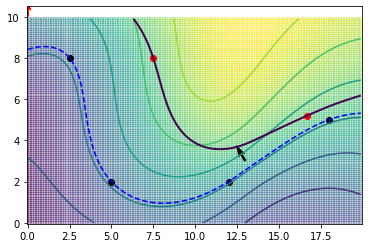

In [6]:
G_t = np.array([[0,10]])
G_t_o = np.array([[0,1]])
r_t = 20
layer_t = np.array([[7.5,8],[16.7,5.2]])

G_d = np.array([[13,3]])
G_d_o = np.array([[-1,1.7]])
r_d = 15
layer_d = np.array([[2.5,8],[5,2],[12,2],[18,5]])

external_kriging(G_t,G_t_o,layer_t,r_t,G_d,G_d_o,layer_d,r_d)

C:\Users\yangj\AppData\Local\Temp\ipykernel_19592\1323483696.py:2: RuntimeWarning: invalid value encountered in sqrt
  sqd = np.sqrt(np.reshape(np.sum(x_1**2,1),newshape =(x_1.shape[0],1))+\
C:\Users\yangj\AppData\Local\Temp\ipykernel_19592\583114262.py:116: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_d = np.linalg.lstsq(K_D_d,bk_d)[0]
C:\Users\yangj\AppData\Local\Temp\ipykernel_19592\583114262.py:277: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w_t = np.linalg.lstsq(K_D_t,bk_t)[0]


[-0.38335855  0.25583705]


C:\Users\yangj\AppData\Local\Temp\ipykernel_19592\583114262.py:332: UserWarning: No contour levels were found within the data range.
  cs = plt.contour(XX,YY,intp_d,levels=lvl_d,colors='b',linestyles='dashed')


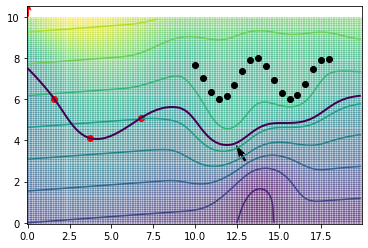

In [7]:
G_t = np.array([[0,10]])
G_t_o = np.array([[0,1]])
r_t = 10
layer_t = np.array([[1.6,6],[3.75,4.1],[6.8,5.1]])

G_d = np.array([[13,3]])
G_d_o = np.array([[-1,1.7]])
r_d = 5

x = np.linspace(10,18,18)
y = np.sin(1.5*x)+7
layer_d = np.stack([x,y],axis=-1)
#layer_d = np.array([[7.5,8],[8,6],[9.5,4],[11,5],[12.5,4],[14,5]])

external_kriging(G_t,G_t_o,layer_t,r_t,G_d,G_d_o,layer_d,r_d)